- [Google mediapipe Playground](https://mediapipe-studio.webapps.google.com/studio/demo/pose_landmarker)
- [Mediapipe 姿勢偵測範例程式參考1](https://steam.oxxostudio.tw/category/python/ai/ai-mediapipe-pose.html)
- [3D視覺－1.人體姿態估計範例程式參考2](https://zhuanlan.zhihu.com/p/528667335)
- [3D影像姿態估計(待實作)](https://blog.csdn.net/kalakalabala/article/details/135272822)
- [動物姿態偵測 DeepLabCut]()

In [1]:
# Ploty version
# https://stackoverflow.com/questions/69265059/is-it-possible-to-create-a-plotly-animated-3d-scatter-plot-of-mediapipes-body-p
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

_PRESENCE_THRESHOLD = 0.5
_VISIBILITY_THRESHOLD = 0.5


def plot_landmarks(
    landmark_list,
    connections=None,
):
    if not landmark_list:
        return
    plotted_landmarks = {}
    for idx, landmark in enumerate(landmark_list.landmark):
        if (
            landmark.HasField("visibility")
            and landmark.visibility < _VISIBILITY_THRESHOLD
        ) or (
            landmark.HasField("presence") and landmark.presence < _PRESENCE_THRESHOLD
        ):
            continue
        plotted_landmarks[idx] = (-landmark.z, landmark.x, -landmark.y)
    if connections:
        out_cn = []
        num_landmarks = len(landmark_list.landmark)
        # Draws the connections if the start and end landmarks are both visible.
        for connection in connections:
            start_idx = connection[0]
            end_idx = connection[1]
            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(
                    f"Landmark index is out of range. Invalid connection "
                    f"from landmark #{start_idx} to landmark #{end_idx}."
                )
            if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
                landmark_pair = [
                    plotted_landmarks[start_idx],
                    plotted_landmarks[end_idx],
                ]
                out_cn.append(
                    dict(
                        xs=[landmark_pair[0][0], landmark_pair[1][0]],
                        ys=[landmark_pair[0][1], landmark_pair[1][1]],
                        zs=[landmark_pair[0][2], landmark_pair[1][2]],
                    )
                )
        cn2 = {"xs": [], "ys": [], "zs": []}
        for pair in out_cn:
            for k in pair.keys():
                cn2[k].append(pair[k][0])
                cn2[k].append(pair[k][1])
                cn2[k].append(None)

    df = pd.DataFrame(plotted_landmarks).T.rename(columns={0: "z", 1: "x", 2: "y"})
    df["lm"] = df.index.map(lambda s: mp_pose.PoseLandmark(s).name).values
    fig = (
        px.scatter_3d(df, x="z", y="x", z="y", hover_name="lm")
        .update_traces(marker={"color": "red"})
        .update_layout(
            margin={"l": 0, "r": 0, "t": 0, "b": 0},
            scene={"camera": {"eye": {"x": 2.1, "y": 0, "z": 0}}},
        )
    )
    fig.add_traces(
        [
            go.Scatter3d(
                x=cn2["xs"],
                y=cn2["ys"],
                z=cn2["zs"],
                mode="lines",
                line={"color": "black", "width": 5},
                name="connections",
            )
        ]
    )
    # fig.write_html("output.html")
    return fig

In [14]:
import numpy as np
def angle_btn_3points(p1,p2,p3):
    p1 = np.array(p1) 
    p2 = np.array(p2) 
    p3 = np.array(p3)
    radians = np.arctan2(p3[1]-p2[1], p3[0]-p2[0]) - np.arctan2(p1[1]-p2[1], p1[0]-p2[0])
    angle = np.abs(radians*180.0/np.pi)
    if angle >180.0:
        angle = 360-angle
    return angle

landmarks = results.pose_landmarks.landmark
kp = mp_pose.PoseLandmark

# Get coordinates and angle (Left Knee angle)
p1 = [landmarks[kp.LEFT_HIP.value].x,landmarks[kp.LEFT_HIP.value].y]
p2 = [landmarks[kp.LEFT_KNEE.value].x,landmarks[kp.LEFT_KNEE.value].y]
p3 = [landmarks[kp.LEFT_ANKLE.value].x,landmarks[kp.LEFT_ANKLE.value].y]
DL = angle_btn_3points(p1, p2, p3)  
# Get coordinates and angle (Right Knee angle)
p1 = [landmarks[kp.RIGHT_HIP.value].x,landmarks[kp.RIGHT_HIP.value].y]
p2 = [landmarks[kp.RIGHT_KNEE.value].x,landmarks[kp.RIGHT_KNEE.value].y]
p3 = [landmarks[kp.RIGHT_ANKLE.value].x,landmarks[kp.RIGHT_ANKLE.value].y]
DR = angle_btn_3points(p1, p2, p3)

DL

175.0610078200439

(314, 547)

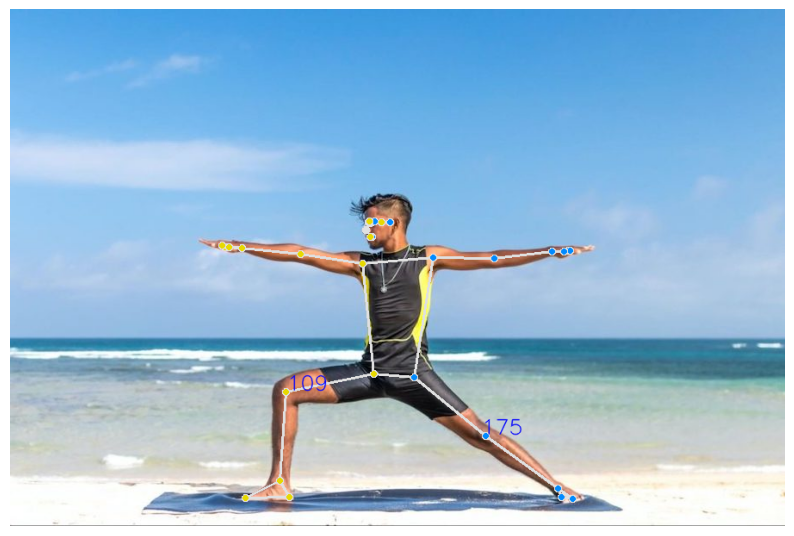

In [50]:
import cv2
# import math
# import numpy as np
from pathlib import Path
import mediapipe as mp
import matplotlib.pyplot as plt


img = cv2.imread("./image/warrier2_sketch.jpeg")                   # 載入影像
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # 將 BGR 轉換成 RGB
mp_pose = mp.solutions.pose                     # mediapipe 姿勢偵測
mp_drawing = mp.solutions.drawing_utils         # mediapipe 繪圖方法
mp_drawing_styles = mp.solutions.drawing_styles # mediapipe 姿勢偵測

# 建立姿勢偵測物件
pose = mp_pose.Pose(
    static_image_mode=True, min_detection_confidence=0.5, model_complexity=2
)
# 取得姿勢偵測結果(輸入影像必為RGB順序)
results = pose.process(img)

# 根據姿勢偵測結果，標記身體節點和骨架
mp_drawing.draw_landmarks(img, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                         landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

plt.figure(figsize=[10, 10])
cv2.putText(img, f'{int(DL)}', (int(landmarks[kp.LEFT_KNEE.value].x*900),int(landmarks[kp.LEFT_KNEE.value].y*600)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 1, lineType=cv2.LINE_AA)
cv2.putText(img, f'{int(DR)}', (int(landmarks[kp.RIGHT_KNEE.value].x*900),int(landmarks[kp.RIGHT_KNEE.value].y*600)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 1, lineType=cv2.LINE_AA)
plt.imshow(img)
plt.axis("off")
cv2.imwrite('output.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR) )


# mp_drawing.plot_landmarks(
#         results.pose_world_landmarks,  mp_pose.POSE_CONNECTIONS)
plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

In [21]:
p3

[0.34987953305244446, 0.9130228161811829]

In [5]:
# import cv2
# import mediapipe as mp
# import matplotlib.pyplot as plt

# if __name__ == '__main__':
#     mp_pose = mp.solutions.pose
#     pose = mp_pose.Pose(static_image_mode=True,
#                         model_complexity=2,
#                         smooth_landmarks=True,
#                         # enable_segmentation=True,
#                         min_detection_confidence=0.5,
#                         min_tracking_confidence=0.5)
    
#     drawing = mp.solutions.drawing_utils

#     # read img BGR to RGB
#     img = cv2.imread("test4.png")
#     results = pose.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     drawing.draw_landmarks(img, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
#     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     plt.axis("off")
#     cv2.imwrite('output.jpg', img)

#     drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

In [ ]:
# !pip install open3d
# !pip install cufflinks

## 使用 holistic

- [reference](https://aitechtogether.com/python/50812.html)

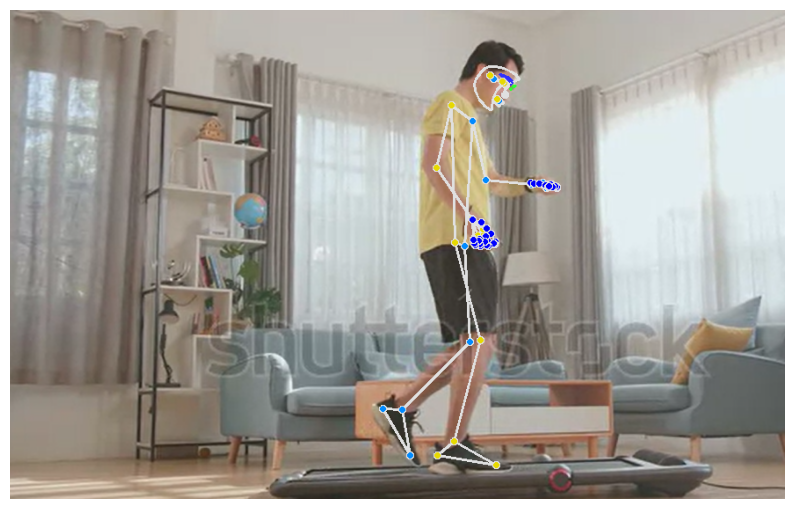

In [6]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic

with mp_holistic.Holistic(
    model_complexity=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as holistic:

    # 載入影像
    image = cv2.imread("./image/test1.png")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = holistic.process(image)
    # 繪製人臉
    mp_drawing.draw_landmarks(
        image,
        results.face_landmarks,
        mp_holistic.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
        .get_default_face_mesh_contours_style())
    # 繪製骨架
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_holistic.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles
        .get_default_pose_landmarks_style())
    # 繪製雙手
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

    #右手21個節點座標
    # if results.right_hand_landmarks:
    #     for index, landmarks  in enumerate(results.right_hand_landmarks.landmark):
    #         print(index,landmarks )
    #鼻子座標
    #print(results.pose_landmarks.landmark[mp_holistic.PoseLandmark.NOSE])
    plt.figure(figsize=[10, 10])
    plt.imshow(image)
    plt.axis("off")